In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler

In [2]:
"""
Read in the data, we are only interested in headlines and category. 
One hot encode the categories
"""
# df = pd.read_json("data/News_Category_Dataset_v3.json", lines=True)
df = pd.read_csv("data/train.csv")

target = ['Response']
boolean_vars = ['Gender', 'Driving_License', 'Previously_Insured', 
                'Vehicle_Damage']
num_vars = ['Age', 'Annual_Premium', 'Vintage']
cat_vars = ['Region_Code', 'Vehicle_Age', 'Policy_Sales_Channel']

# Turn the boolean variables into 0 and 1
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
df[boolean_vars] = df[boolean_vars].astype('float16')

# Standardize The numerical variables
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars]).astype('float16')

for col in df.columns:
    print(col)

# One hot encode the categorical variables
df = pd.get_dummies(df, columns=cat_vars, dtype='float16')


# Downscale Majority class 10 times to even out the classes 
majorityClass = df.where(df['Response'] == 0).dropna()
minorityClass = df.where(df['Response'] == 1).dropna()
minorityCount = len(minorityClass)
downSampled = majorityClass.sample(n=minorityCount, random_state=42)
df = pd.concat([downSampled, minorityClass]) 

# Save the data
df.to_csv("processedData.csv", index=False)


id
Gender
Age
Driving_License
Region_Code
Previously_Insured
Vehicle_Age
Vehicle_Damage
Annual_Premium
Policy_Sales_Channel
Vintage
Response


In [ ]:
from sklearn.model_selection import train_test_split

"""
Split the data into training and testing
"""
def splitTrainingData(df, featureCols, targetCol, random=False):
    state = 42 if random else None
    X = df[featureCols]
    y = df[targetCol]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
    return X_train, X_test, y_train, y_test


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.initializers import HeNormal
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.layers import Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.losses import BinaryCrossentropy 
from sklearn.metrics import recall_score
import numpy as np


class B3D3AD_Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.classes_ = np.array([0, 1])  
        self.model = Sequential([
            self.DenseLayer(4096, activation='relu'),
            self.DenseLayer(512, activation='relu'),
            self.DenseLayer(512, activation='relu'),
            self.DenseLayer(512, activation='relu'),
            self.DropoutLayer(0.3),
            self.DenseLayer(1, activation='sigmoid'),
        ])

    # Customer Dense layer
    def DenseLayer(self, nodes, activation='relu'):
        return Dense(
            nodes, activation=activation, 
            kernel_initializer=HeNormal(), bias_initializer=HeNormal(),
            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
        )

    # Custom dropout layer
    def DropoutLayer(self, rate):
        return Dropout(rate)

    # Resets weights to HeNormal
    def reset_weights(self):
        initial_weights = self.model.get_weights()
        self.model.set_weights(initial_weights)

    def predict(self, X, threshold=0.5):
        # Predict probabilities
        probabilities = self.model.predict(X)
        # Convert probabilities to binary predictions using the threshold
        predictions = (probabilities >= threshold).astype(int)
        return predictions

    # compile the model
    def compile(self):
        self.model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

    # Calculate recall
    def recall(self, X, y):
        predictions = self.predict(X)
        return recall_score(y, predictions)

    # Run the model. Forward fit using a learning rate scheduler
    def fit(self, X, training_labels, epochs=5, batch_size=32):
        lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1, decay_rate=.1)
        self.compile()
        self.model.fit(X, training_labels, epochs=epochs, 
                    batch_size=batch_size, callbacks=[LearningRateScheduler(lr_scheduler)])

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Region_Code_1.0,Region_Code_2.0,Region_Code_3.0,...,Policy_Sales_Channel_60.0,Policy_Sales_Channel_63.0,Policy_Sales_Channel_122.0,Policy_Sales_Channel_124.0,Policy_Sales_Channel_136.0,Policy_Sales_Channel_147.0,Policy_Sales_Channel_152.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_160.0
3,1.0,-0.3000,1.0,0.0,1.0,-1.71300,-0.4370,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,1.0,0.2986,1.0,0.0,1.0,0.40230,1.4110,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,-0.3750,1.0,0.0,1.0,-0.10190,-0.7305,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15,1.0,-0.8237,1.0,0.0,1.0,0.05798,0.7010,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


3     0.0
13    1.0
16    1.0
15    1.0
Name: Response, dtype: float64

Epoch 1/5
1/1 [==============================] - 1s 690ms/step - loss: 114.2379 - accuracy: 0.4444 - lr: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 113.1159 - accuracy: 0.5556 - lr: 1.0000e-04
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 112.9137 - accuracy: 0.5556 - lr: 1.0000e-05
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 112.4116 - accuracy: 0.5556 - lr: 1.0000e-06
Epoch 5/5
1/1 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - 1s 672ms/step - loss: 114.6023 - accuracy: 0.4444 - lr: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 113.1573 - accuracy: 0.5556 - lr: 1.0000e-04
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 112.6517 - accuracy: 0.5556 - lr: 1.0000e-05
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 112.5492 - accuracy: 0.5556 - lr: 1.0000e-06
Epoch 5/5
1/1 [=========

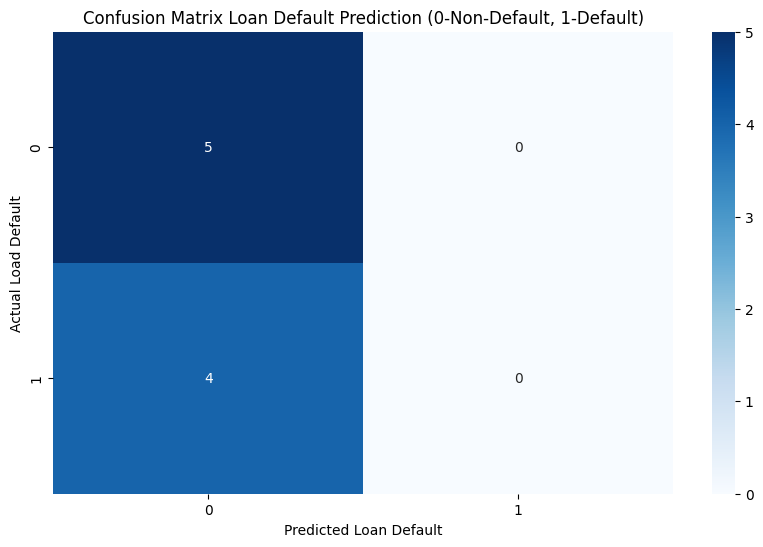

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns


def train():
    # Load the data
    data = pd.read_csv("processedData.csv")

    # Split features and target columns
    columns = data.columns.drop('Response')
    X = data[columns]
    y = data['Response']
    X_train, X_test, y_train, y_test = splitTrainingData(data, columns, 'Response', random=True)

    display(X_train.head(4))
    display(y_train.head(4))

    # Initialize the k-fold cross-validator
    k_folds = 2  # Choose the number of folds
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize lists to store evaluation results
    accuracies = []
    recalls = []

    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on a custom Model Class (NLTK_Binary_Classifier)
        model = B3D3AD_Classifier()
        model.fit(X_train, y_train)  # Assuming your fit method works with your custom class

        # Evaluate the model
        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)
        recall = model.recall(X_test, y_test)
        recalls.append(recall)

    # Calculate and print the mean accuracy
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Mean recall: {np.mean(recalls)}")

     # Display the Confusion Matrix
    conf_matrix = confusion_matrix(y_train,  model.model.predict(X_train).round()) 
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Loan Default')
    plt.ylabel('Actual Load Default')
    plt.title('Confusion Matrix Loan Default Prediction (0-Non-Default, 1-Default)')
    plt.show()

train()